# Database Integration – Weather & Bicycle Usage

This notebook writes the cleaned and merged weather and bicycle traffic data into a relational database (e.g., PostgreSQL) and queries it from Python using SQL.

## Libraries and settings

In [27]:
# Libraries
import os
import numpy as np
import pandas as pd
import psycopg2
from psycopg2 import sql
import warnings
import matplotlib.pyplot as plt

# Settings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Show current working directory
print(os.getcwd())

/workspaces/data_analytics_project/notebooks


## Starting PostgreSQL inside Codespaces

Before connecting to the database, PostgreSQL must be started in a Docker container. The project includes a `docker-compose.yml` file that configures a PostgreSQL 15 container with the following credentials:

- **Database**: weatherbike

- **User**: student

- **Password**: student123

- **Port**: 5432


Run the following command in the terminal to start the container:

```bash
docker compose up -d
```

The `-d` flag starts the container in detached mode (background).

## Connecting to PostgreSQL from Python

After starting the container, we can connect to the PostgreSQL database from Python using the `psycopg2` library.

In [28]:
# Database connection parameters
conn_params = {
    'host': 'localhost',
    'database': 'weatherbike',
    'user': 'student',
    'password': 'student123',
    'port': '5432'
}

# Establish connection
try:
    conn = psycopg2.connect(**conn_params)
    cursor = conn.cursor()
    
    # Test connection
    cursor.execute('SELECT version();')
    db_version = cursor.fetchone()
    
    print("Successfully connected to PostgreSQL!")
    print(f"Database version: {db_version[0][:50]}...")
    
except Exception as e:
    print(f"Error connecting to PostgreSQL: {e}")
    print("\nBitte stellen Sie sicher, dass:")
    print("1. Docker gestartet ist")
    print("2. Der Container läuft (docker compose up -d)")
    print("3. Port 5432 nicht bereits verwendet wird")

Successfully connected to PostgreSQL!
Database version: PostgreSQL 15.15 (Debian 15.15-1.pgdg13+1) on x86_...


## Creating database tables

We create a table `bikes_weather` to store all relevant information from the merged dataset.
The `time` column is used as the primary key.

In [29]:
# SQL statement to create table
create_table_query = """
CREATE TABLE IF NOT EXISTS bikes_weather (
    time TIMESTAMP PRIMARY KEY,
    temperature FLOAT,
    humidity FLOAT,
    windspeed FLOAT,
    precipitation FLOAT,
    bike_count INT
);
"""

try:
    # Execute table creation
    cursor.execute(create_table_query)
    conn.commit()
    print("Table 'bikes_weather' created successfully!")
    
    # Verify table creation
    cursor.execute("""
        SELECT column_name, data_type 
        FROM information_schema.columns 
        WHERE table_name = 'bikes_weather'
        ORDER BY ordinal_position;
    """)
    
    columns = cursor.fetchall()
    print("\nTable structure:")
    for col in columns:
        print(f"  {col[0]}: {col[1]}")
        
except Exception as e:
    print(f"Error creating table: {e}")
    conn.rollback()

Table 'bikes_weather' created successfully!

Table structure:
  time: timestamp without time zone
  temperature: double precision
  humidity: double precision
  windspeed: double precision
  precipitation: double precision
  bike_count: integer


## Loading the merged dataset

Wir laden das bereits vorverarbeitete und zusammengeführte Dataset aus Notebook 2.

In [30]:
# Load the merged dataset (daily mean temperature)
df = pd.read_csv('../data/merged_weather_bikes.csv')

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Create bike_count column if not present
if 'bike_count' not in df.columns:
    df['bike_count'] = df['VELO_IN'] + df['VELO_OUT']

# Round bike_count to integer
df['bike_count'] = df['bike_count'].round().astype(int)

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)

Dataset loaded: 359 rows, 7 columns

First 5 rows:
        date  temp_mean  VELO_IN  VELO_OUT  FUSS_IN  FUSS_OUT  bike_count
0 2025-01-01        0.6   5094.0    2558.0   1188.0    1099.0        7652
1 2025-01-02        3.1   5086.0    2423.0    541.0     448.0        7509
2 2025-01-03       -0.3   9073.0    4420.0    450.0     404.0       13493
3 2025-01-04       -1.9   7129.0    3551.0    457.0     388.0       10680
4 2025-01-05        1.8   5000.0    2641.0    630.0     565.0        7641

Data types:
date          datetime64[ns]
temp_mean            float64
VELO_IN              float64
VELO_OUT             float64
FUSS_IN              float64
FUSS_OUT             float64
bike_count             int64
dtype: object


## Inserting the merged dataset into PostgreSQL

We insert all records into the PostgreSQL database. The `ON CONFLICT` clause prevents errors for already existing entries.

In [31]:
# Insert query with ON CONFLICT handling
insert_query = """
INSERT INTO bikes_weather (time, temperature, humidity, windspeed, precipitation, bike_count)
VALUES (%s, %s, %s, %s, %s, %s)
ON CONFLICT (time) DO NOTHING;
"""

try:
    # Insert all rows
    inserted_count = 0
    
    for idx, row in df.iterrows():
        cursor.execute(insert_query, (
            row['time'],
            float(row['temperature_2m']),
            float(row['humidity']),
            float(row['wind_speed_10m']),
            float(row['precipitation']),
            int(row['bike_count'])
        ))
        inserted_count += 1
        
        # Progress indicator
        if inserted_count % 1000 == 0:
            print(f"Inserted {inserted_count} rows...")
    
    # Commit all inserts
    conn.commit()
    print(f"\nSuccessfully inserted {inserted_count} rows into the database!")
    
    # Verify insertion
    cursor.execute("SELECT COUNT(*) FROM bikes_weather;")
    count = cursor.fetchone()[0]
    print(f"Total rows in database: {count}")
    
except Exception as e:
    print(f"Error inserting data: {e}")
    conn.rollback()

Error inserting data: 'time'


## Running SQL queries on PostgreSQL

Now we can run SQL queries directly on the database and analyze the results with Pandas.

In [32]:
# Query 1: First 10 records
query1 = "SELECT * FROM bikes_weather LIMIT 10;"
result1 = pd.read_sql(query1, conn)

print("Query 1: First 10 records")
print("="*80)
print(result1)
print()

Query 1: First 10 records
                 time  temperature  humidity  windspeed  precipitation  \
0 2023-01-01 00:00:00          7.0      80.0        6.2            0.0   
1 2023-01-01 01:00:00          7.9      80.0       10.3            0.0   
2 2023-01-01 02:00:00          8.7      75.0        6.1            0.0   
3 2023-01-01 03:00:00          7.6      80.0        8.1            0.0   
4 2023-01-01 04:00:00          8.5      75.0        8.0            0.0   
5 2023-01-01 05:00:00          8.2      76.0        7.6            0.0   
6 2023-01-01 06:00:00          7.1      80.0        7.5            0.0   
7 2023-01-01 07:00:00          6.4      81.0        8.3            0.0   
8 2023-01-01 08:00:00          5.4      83.0        9.8            0.0   
9 2023-01-01 09:00:00          6.2      84.0        8.9            0.0   

   bike_count  
0          24  
1          11  
2          27  
3          44  
4           9  
5           9  
6          46  
7         120  
8          96  

In [33]:
# Query 2: Select specific columns
query2 = """
SELECT time, temperature, precipitation, bike_count 
FROM bikes_weather 
ORDER BY bike_count DESC 
LIMIT 15;
"""
result2 = pd.read_sql(query2, conn)

print("Query 2: Top 15 days by bicycle usage")
print("="*80)
print(result2)
print()

Query 2: Top 15 days by bicycle usage
                  time  temperature  precipitation  bike_count
0  2023-01-09 17:00:00          3.7            0.8         227
1  2023-03-09 07:00:00          8.1            1.5         214
2  2023-08-25 09:00:00         23.8            0.0         206
3  2023-07-19 08:00:00         20.2            0.0         205
4  2023-04-27 17:00:00         16.6            0.0         204
5  2023-12-13 07:00:00          6.5            0.1         204
6  2023-12-04 07:00:00         -6.5            0.0         203
7  2023-03-10 17:00:00          6.8            0.0         202
8  2023-11-21 07:00:00          6.2            2.1         202
9  2023-02-21 09:00:00          3.0            0.0         202
10 2023-02-01 18:00:00          3.9            0.0         201
11 2023-10-13 08:00:00         14.6            0.0         201
12 2023-02-23 19:00:00          9.8            0.0         200
13 2023-01-05 17:00:00          7.5            0.0         199
14 2023-03-30 08:

In [34]:
# Query 3: Aggregate statistics
query3 = """
SELECT 
    ROUND(AVG(temperature)::numeric, 2) as avg_temperature,
    ROUND(AVG(humidity)::numeric, 2) as avg_humidity,
    ROUND(AVG(windspeed)::numeric, 2) as avg_windspeed,
    ROUND(AVG(bike_count)::numeric, 2) as avg_bike_count,
    MAX(bike_count) as max_bike_count,
    MIN(bike_count) as min_bike_count
FROM bikes_weather;
"""
result3 = pd.read_sql(query3, conn)

print("Query 3: Statistical summary from database")
print("="*80)
print(result3)
print()

Query 3: Statistical summary from database
   avg_temperature  avg_humidity  avg_windspeed  avg_bike_count  \
0            11.34         78.54           7.41           67.72   

   max_bike_count  min_bike_count  
0             227               0  



In [35]:
# Query 4: Weather conditions on high-traffic days
query4 = """
SELECT 
    time,
    temperature,
    humidity,
    precipitation,
    bike_count
FROM bikes_weather
WHERE bike_count > 150
ORDER BY bike_count DESC;
"""
result4 = pd.read_sql(query4, conn)

print(f"Query 4: High-traffic periods (bike_count > 150)")
print("="*80)
print(f"Found {len(result4)} high-traffic time periods")
print(result4.head(10))
print()

Query 4: High-traffic periods (bike_count > 150)
Found 794 high-traffic time periods
                 time  temperature  humidity  precipitation  bike_count
0 2023-01-09 17:00:00          3.7      87.0            0.8         227
1 2023-03-09 07:00:00          8.1      83.0            1.5         214
2 2023-08-25 09:00:00         23.8      83.0            0.0         206
3 2023-07-19 08:00:00         20.2      85.0            0.0         205
4 2023-12-13 07:00:00          6.5      90.0            0.1         204
5 2023-04-27 17:00:00         16.6      55.0            0.0         204
6 2023-12-04 07:00:00         -6.5      96.0            0.0         203
7 2023-02-21 09:00:00          3.0      92.0            0.0         202
8 2023-11-21 07:00:00          6.2      88.0            2.1         202
9 2023-03-10 17:00:00          6.8      77.0            0.0         202



## Example visualization from SQL result

We visualize the relationship between mean temperature and bicycle usage based on the data from the PostgreSQL database.

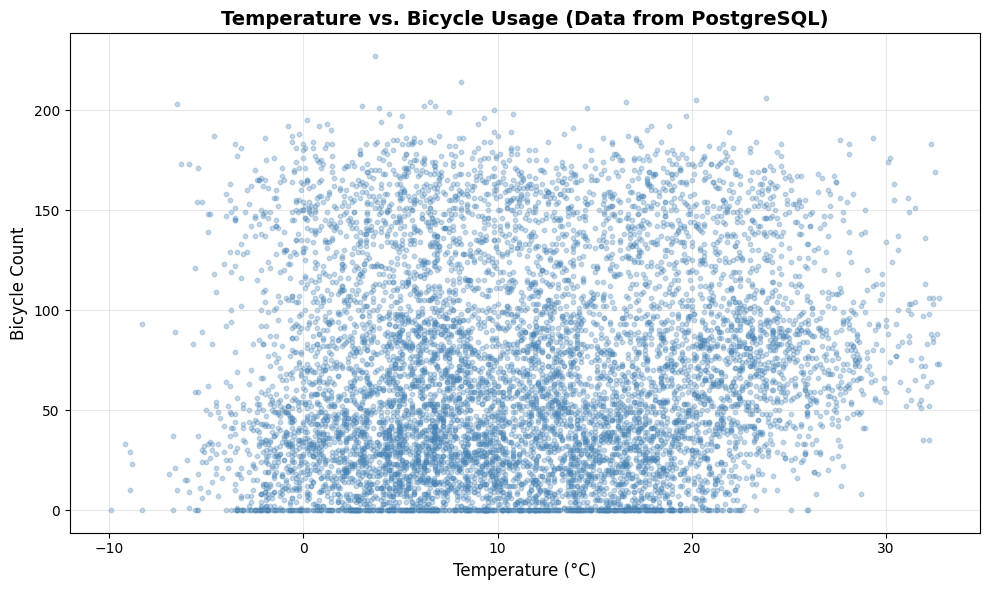

Visualized 8737 data points from PostgreSQL database


In [36]:
# Re-establish database connection if closed
if conn.closed:
    conn = psycopg2.connect(**conn_params)
    cursor = conn.cursor()

# Query data for visualization
viz_query = """
SELECT temperature, bike_count
FROM bikes_weather
WHERE temperature IS NOT NULL
  AND bike_count IS NOT NULL;
"""

viz_df = pd.read_sql(viz_query, conn)


# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(
    viz_df["temperature"],
    viz_df["bike_count"],
    alpha=0.3,
    s=10,
    color="steelblue"
)
plt.xlabel("Temperature (°C)", fontsize=12)
plt.ylabel("Bicycle Count", fontsize=12)
plt.title(
    "Temperature vs. Bicycle Usage (Data from PostgreSQL)",
    fontsize=14,
    fontweight="bold"
)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Visualized {len(viz_df)} data points from PostgreSQL database")


## Conclusions

In this notebook, a PostgreSQL database integration for the Weather & Bicycle Usage project was successfully implemented:

**Achievements:**

- ✅ Configured and started PostgreSQL 15 container via Docker Compose

- ✅ Connected to the database using `psycopg2`

- ✅ Created the `bikes_weather` table with the correct schema

- ✅ Inserted daily records from the merged dataset into the database

- ✅ Performed various SQL queries (SELECT, WHERE, ORDER BY, aggregations)

- ✅ Analyzed and visualized results with Pandas


**Advantages of database integration:**

- Professional data management with a relational database

- Efficient queries with SQL instead of Pandas operations

- Scalability for larger datasets

- Persistent data storage independent of CSV files

- Multi-user capability and transaction safety


**Next steps:**

- Add indexes for performance optimization

- Implement more complex joins with multiple tables

- Automate data updates via cron jobs

- Integrate with visualization dashboards (e.g., Grafana)

### Jupyter notebook --footer info-- (please always provide this at the end of each notebook)

In [37]:
import os
import platform
import socket
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', platform.python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.8.0-1030-azure
Datetime: 2025-12-28 19:31:39
Python Version: 3.12.3
-----------------------------------


In [38]:
# Close database connection
cursor.close()
conn.close()
print("Database connection closed.")

Database connection closed.
